In [1]:
import IPython
import numpy as np
from ipywidgets import Image
#
from Bio.PDB import PDBParser, PDBIO
#
import openmm
import openmm.app
from openmm.app import PDBFile
from openmm.app import CheckpointReporter
#
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity, unit
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND
from openff.pablo import topology_from_pdb
from openff.interchange import Interchange
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
import sys
sys.path.append('..')
from ptm_prototype import draw_molecule
from ptm_prototype import react_mod
from ptm_prototype import parametrize_with_nagl
#
import rdkit
from rdkit import Chem
from rdkit import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from rdkit.Chem.rdchem import AtomPDBResidueInfo
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
draw_options = Chem.Draw.MolDrawOptions()
draw_options.addAtomIndices = True
print(rdkit.__version__)

2025.03.6


clean raw crystal structure by bio.PDB, which remove redundant ANISOU lines, affording 9BFX_clean_biopdb.pdb

In [2]:
parser = PDBParser()
structure = parser.get_structure("9BFX_clean", "9BFX_clean.pdb")
io = PDBIO()
io.set_structure(structure)
io.save("9BFX_clean_biopdb.pdb")

1. use pymol to extract GNP, MG and (covalent ligand + CYS) to seperate file respectively (CYSLIG_clean.sdf, GNP_clean.pdb and MG.pdb), only keep protein structure (9BFX_clean_biopdb_protein_only.pdb)
2. use openmm-setup (in conda environment: openfe_env) to prepare protein with protonations, affording 9BFX_clean_biopdb_protein_only-processed.pdb
3. remove redundant morphic sidechain atoms from crystal fitted structure (e.g., ILE:142 C01...C05; ASP:154 N01/C01...C08), affording final_protein_only.pdb
4. delete covalent cys, affording final_protein_only_no_cys.pdb

prepare (ligand + cys) as non-caniconl amino acid (using CYSLIG_clean.sdf containg OXT and all hydrogen atoms, which need pymol to build them)

In [ ]:
#use openff.pablo to generate non-canical amino acid topology
cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()
Elironrasib = Molecule.from_smiles("C[C@H](OC)C(N=CC=C1)=[C@@]1[C@](N2CC)=C(CC(C)(C)COC([C@H]3NN(C([C@@H](NC([C@H](C(C)C)N(C(C4(F)CCN(C(C#CC(N(C)C)(C)C)=O)CC4)=O)C)=O)C[C@H]5CN6CCO5)=O)CCC3)=O)C7=C2C=CC6=C7")
Elironrasib.generate_unique_atom_names()
#rdkit SMARTS reaction to conjugate two motifs together, forming cis-configuration (consistent with crystal structure) 
covalent_triple_bond_smarts_cis = '[C:10]-[S:1]-[H:2].[C:11]-[C:3]#[C:4]-[C:5](=[O:6])-[N:7](-[C:8])-[C:9]>>[C:10]-[S:1]/[C:3](-[C:11])=[C:4](/[H])[C:5](=[O:6])-[N:7](-[C:8])-[C:9]'
rxn = ReactionFromSmarts(covalent_triple_bond_smarts_cis)
d2d = Draw.MolDraw2DCairo(800, 300)
d2d.DrawReaction(rxn, highlightByReactant=True)
Image(value=d2d.GetDrawingText())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x01,\x08\x02\x00\x00\x00\xb4O@m\x00\x00…

In [4]:
# The adduct of non-conical amino acid with random conformer generated for topology 
products = list(react_mod([cysteine, Elironrasib], covalent_triple_bond_smarts_cis))
adduct = products[0][0]
adduct

[11:49:13] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 


/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


NGLWidget()

In [5]:
#check 2D structure with atom name, noticing a hydrogen name at conjugate side is missing, so we need to add its name manually
draw_molecule(
    adduct,
    width=1500,
    height=750,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(adduct.atoms)
    },
)
adduct.atom(5).name = 'H79x'

In [6]:
#add adduct as a non-canical amino acid into openff database
ligand_resdef = ResidueDefinition.from_molecule(
    molecule=adduct,
    residue_name="LIG",
    linking_bond=PEPTIDE_BOND,
)

In [7]:
'''
def remove_proton_from_serine_or_threonine(openff_molecule: Molecule) -> Molecule:
    rd_mol = openff_molecule.to_rdkit()
    rw_mol = Chem.RWMol(rd_mol)
    hg_atom_index = None
    for atom in rw_mol.GetAtoms():
        if atom.GetSymbol() == 'H' and atom.GetIdx() == 12:
            for neighbor in atom.GetNeighbors():
                if neighbor.GetSymbol() == 'O':
                    hg_atom_index = atom.GetIdx()
                    oxygen_atom_index = neighbor.GetIdx()
                    break
        if hg_atom_index is not None:
            break

    if hg_atom_index is not None:
        oxygen_atom = rw_mol.GetAtomWithIdx(oxygen_atom_index)
        oxygen_atom.SetFormalCharge(-1)
        rw_mol.RemoveAtom(hg_atom_index)
        Chem.SanitizeMol(rw_mol)
        new_openff_molecule = Molecule.from_rdkit(rw_mol.GetMol())
        return new_openff_molecule
    else:
        print("HG proton not found on serine residue.")
        return openff_molecule
#
serine = CCD_RESIDUE_DEFINITION_CACHE["SER"][0].to_openff_molecule()    
serine_noH = remove_proton_from_serine_or_threonine(serine)
sen_resdef = ResidueDefinition.from_molecule(
    molecule=serine_noH,
    residue_name="SEN",
    linking_bond=PEPTIDE_BOND,
)
#
threonine = CCD_RESIDUE_DEFINITION_CACHE["THR"][0].to_openff_molecule()
threonine_noH = remove_proton_from_serine_or_threonine(threonine)
thn_resdef = ResidueDefinition.from_molecule(
    molecule=threonine_noH,
    residue_name="THN",
    linking_bond=PEPTIDE_BOND,
)
'''

'\ndef remove_proton_from_serine_or_threonine(openff_molecule: Molecule) -> Molecule:\n    rd_mol = openff_molecule.to_rdkit()\n    rw_mol = Chem.RWMol(rd_mol)\n    hg_atom_index = None\n    for atom in rw_mol.GetAtoms():\n        if atom.GetSymbol() == \'H\' and atom.GetIdx() == 12:\n            for neighbor in atom.GetNeighbors():\n                if neighbor.GetSymbol() == \'O\':\n                    hg_atom_index = atom.GetIdx()\n                    oxygen_atom_index = neighbor.GetIdx()\n                    break\n        if hg_atom_index is not None:\n            break\n\n    if hg_atom_index is not None:\n        oxygen_atom = rw_mol.GetAtomWithIdx(oxygen_atom_index)\n        oxygen_atom.SetFormalCharge(-1)\n        rw_mol.RemoveAtom(hg_atom_index)\n        Chem.SanitizeMol(rw_mol)\n        new_openff_molecule = Molecule.from_rdkit(rw_mol.GetMol())\n        return new_openff_molecule\n    else:\n        print("HG proton not found on serine residue.")\n        return openff_molecu

In [8]:
#check extracted (ligand+cys) structure to have consistent 2D with just defined openff topology (by conical smiles) 
#load (ligand+cys) fragment extracted from pdb structure (rdkit read 3D sdf but ignore hydrogens, so we have to add them again) 
suppl = Chem.SDMolSupplier('CYSLIG_clean.sdf')[0]
suppl_H = Chem.AddHs(suppl, addCoords=True)
Elironrasib_ref_H_canonical_smiles = Chem.MolToSmiles(suppl_H, canonical=True)
print(Elironrasib_ref_H_canonical_smiles)
#convert openff topology to rdkit mol object for checking
adduct_mol_H = adduct.to_rdkit()
Elironrasib_top_H_canonical_smiles = Chem.MolToSmiles(adduct_mol_H, canonical=True)
print(Elironrasib_top_H_canonical_smiles)

[H]OC(=O)[C@@]([H])(N([H])[H])C([H])([H])S/C(=C(/[H])C(=O)N1C([H])([H])C([H])([H])C(F)(C(=O)N(C([H])([H])[H])[C@]([H])(C(=O)N([H])[C@]2([H])C(=O)N3N([H])[C@]([H])(C(=O)OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])c4c(-c5c([C@@]([H])(OC([H])([H])[H])C([H])([H])[H])nc([H])c([H])c5[H])n(C([H])([H])C([H])([H])[H])c5c([H])c([H])c(c([H])c45)N4C([H])([H])C([H])([H])O[C@]([H])(C4([H])[H])C2([H])[H])C([H])([H])C([H])([H])C3([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H])C(N(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
[H]OC(=O)[C@@]([H])(N([H])[H])C([H])([H])S/C(=C(/[H])C(=O)N1C([H])([H])C([H])([H])C(F)(C(=O)N(C([H])([H])[H])[C@]([H])(C(=O)N([H])[C@]2([H])C(=O)N3N([H])[C@]([H])(C(=O)OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C4=C(c5c([C@@]([H])(OC([H])([H])[H])C([H])([H])[H])nc([H])c([H])c5[H])N(C([H])([H])C([H])([H])[H])c5c([H])c([H])c(c([H])c54)N4C([H])([H])C([H])([H])O[C@]([H])(C4([H])[H])C2([H])[H])C([H])([H])C([H])([H])C3([H])[H])

In [9]:
#This step is to reorder atom index from extracted structure, making it consistent with openff topology 
list_1 = list(map(int, adduct_mol_H.GetProp("_smilesAtomOutputOrder")[1:-1].split(",")))
list_2 = list(map(int, suppl_H.GetProp("_smilesAtomOutputOrder")[1:-1].split(",")))
#
res = list(zip(list_2,list_1))
res.sort(key=lambda x: x[1])
unzipped_list_2, unzipped_list_1 = zip(*res)
new_indices = list(unzipped_list_2)
#
suppl_r = Chem.RenumberAtoms(suppl_H, new_indices)

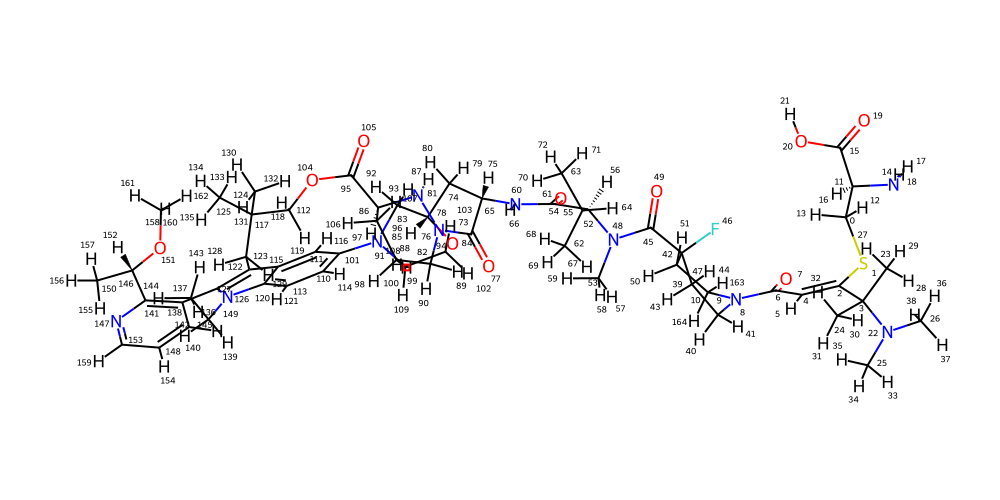

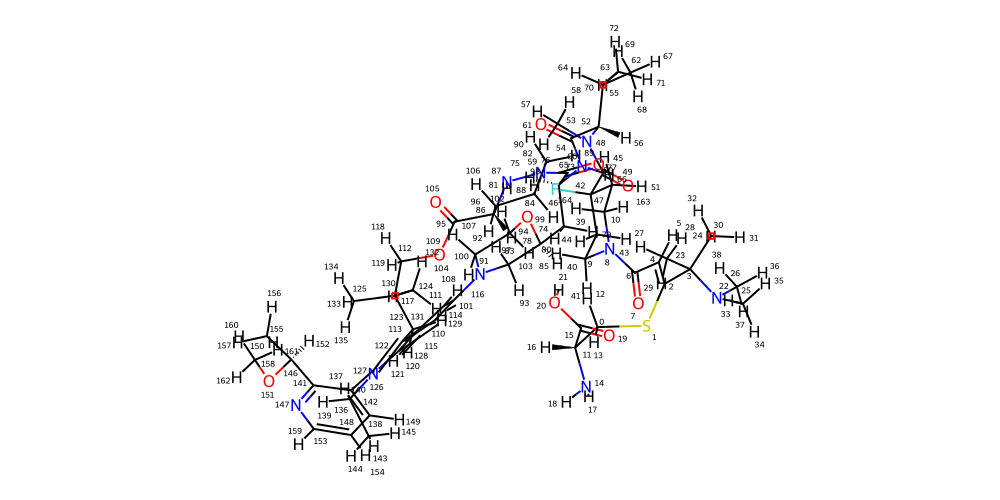

In [10]:
#double check in graph
IPython.display.display(Chem.Draw.MolToImage(adduct_mol_H, size=(1000, 500), options=draw_options))
IPython.display.display(Chem.Draw.MolToImage(suppl_r, size=(1000, 500), options=draw_options))

In [11]:
#rename and save
for i, atom in enumerate(adduct_mol_H.GetAtoms()):
    info = AtomPDBResidueInfo(
        atom.GetProp('_Name'),
        atom.GetIdx() + 1,
        ' ',
        'LIG',
        12,
        'B',
        ' ',
    )    
    suppl_r.GetAtomWithIdx(i).SetMonomerInfo(info)
Chem.MolToPDBFile(suppl_r, 'CYSLIG_clean_renamed.pdb')

insert lines of CYSLIG_clean_renamed.pdb into final_protein_only_no_cys.pdb (no_cys_CYSLIG_renamed.pdb), and remove atoms HXT, OXT and H2 atoms before pymol clean reindex (final_covalent.pdb).

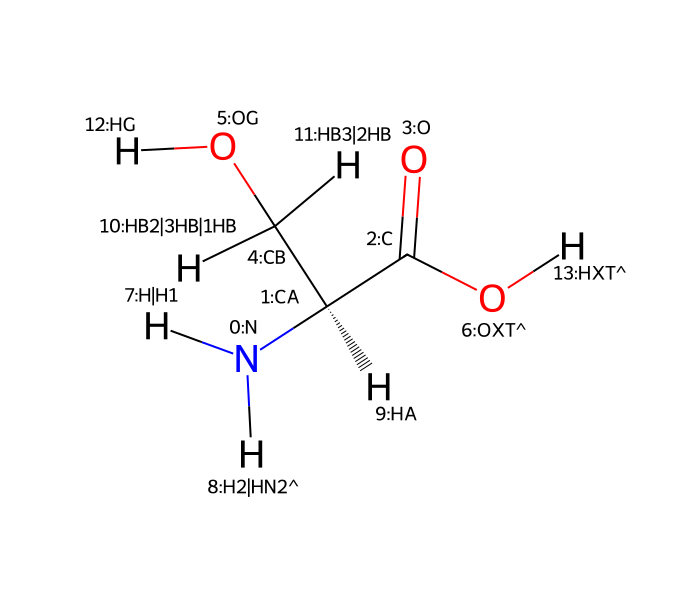

In [12]:
serine = CCD_RESIDUE_DEFINITION_CACHE["SER"][0].to_openff_molecule()
draw_molecule(
    serine,
    width=700,
    height=600,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(serine.atoms)
    },
)

In [13]:
ser_resdef = CCD_RESIDUE_DEFINITION_CACHE["SER"][6]
sen_resdef = ser_resdef.replace(residue_name='SEN', description='SERINE deprotonated')
sen_resdef

ResidueDefinition(residue_name='SEN', description='SERINE deprotonated', linking_bond=BondDefinition(atom1='C', atom2='N', order=1, aromatic=False, stereo=None), crosslink=None, atoms=(AtomDefinition(name='N', synonyms=(), symbol='N', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='CA', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo='S'), AtomDefinition(name='C', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='O', synonyms=(), symbol='O', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='CB', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='OG', synonyms=(), symbol='O', leaving=False, charge=-1, aromatic=False, stereo=None), AtomDefinition(name='OXT', synonyms=(), symbol='O', leaving=True, charge=0, aromatic=False, stereo=None), AtomDefinition(name='H', synonyms=('H1',), symbol='H', leaving=False, charge

In [14]:
thr_resdef = CCD_RESIDUE_DEFINITION_CACHE["THR"][6]
thn_resdef = thr_resdef.replace(residue_name='THN', description='THREONINE deprotonated')
thn_resdef

ResidueDefinition(residue_name='THN', description='THREONINE deprotonated', linking_bond=BondDefinition(atom1='C', atom2='N', order=1, aromatic=False, stereo=None), crosslink=None, atoms=(AtomDefinition(name='N', synonyms=(), symbol='N', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='CA', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo='S'), AtomDefinition(name='C', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='O', synonyms=(), symbol='O', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='CB', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo='R'), AtomDefinition(name='OG1', synonyms=(), symbol='O', leaving=False, charge=-1, aromatic=False, stereo=None), AtomDefinition(name='CG2', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo=None), AtomDefinition(name='OXT', synonyms=(), symbol='O', leaving=True, charge

remove all residue 0 in final_covalent_mod (final_covalent_mod_1) and prepare pdb structure again with openmm-setup (pdbfixer) to get final_covalent_mod_1-processed.pdb. This is for coverting interchange topology to gromacs files.

In [15]:
#build off topology from pdb file
residue_database_1 = CCD_RESIDUE_DEFINITION_CACHE.with_({"LIG": [ligand_resdef]})
residue_database_2 = residue_database_1.with_({"SEN": [sen_resdef]})
residue_database_3 = residue_database_2.with_({"THN": [thn_resdef]})

covalent_topology = topology_from_pdb(
    "final_covalent_mod_1-processed.pdb",
    residue_database=residue_database_3,
)
covalent_topology.box_vectors=None
#
force_field = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")
#
charge_handler = force_field.get_parameter_handler('LibraryCharges')
mg_charge_params = {
    "smirks": "[#12+2:1]",
    "charge1": 2.0 * unit.elementary_charge
}
charge_handler.add_parameter(mg_charge_params)
#
vdw_handler = force_field.get_parameter_handler('vdW')
vdw_params = {
    'smirks': '[#12+2:1]',
    'epsilon': 0.07 * unit.kilocalorie_per_mole,
    'sigma': 1.7 * unit.angstrom,
}
vdw_handler.add_parameter(vdw_params)
#
MG = Molecule.from_pdb_and_smiles('MG.pdb', '[#12+2:1]')
covalent_topology.add_molecule(MG)
#
rdmol = Chem.SDMolSupplier('GNP_H_charged.sdf')[0]
Chem.SanitizeMol(rdmol)
GNP = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
GNP.name = "GNP"
for atom in GNP.atoms:
    atom.metadata['residue_name'] = 'GNP'
covalent_topology.add_molecule(GNP)
#
final_topology = solvate_topology(
    covalent_topology,
    nacl_conc=Quantity(0.1, "mol/L"),
    padding=Quantity(1.0, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)
interchange = parametrize_with_nagl(
    force_field=force_field,
    topology=final_topology,
)

/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/openff/toolkit/utils/base_wrapper.py:67: MoleculeDeprecationWarning: `Molecule.from_pdb_and_smiles` is deprecated in favor of `Topology.from_pdb`, the recommended method for loading PDB files. This method will be removed in a future release of the OpenFF Toolkit.
  value = func(*args, **kwargs)
/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/openff/toolkit/topology/molecule.py:4795: UserWarning: `RDKitToolkitWrapper.from_polymer_pdb` is deprecated in favor of `Topology.from_pdb`, the recommended method for loading PDB files. (Note the `unique_molecules` argument.) This method will be removed in a future release of the OpenFF Toolkit.
  return toolkit.from_pdb_and_smiles(file_path, smiles, allow_undefined_stereo, _cls=cls, name=name)


adding dummy charges to force field ...
making Interchange ...
replacing dummy charges with NAGL charges ... 
assigning graph charges to C904H1418FN241O277S5 ...


[11:50:03] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...
assigning graph charges to GNP ...


[11:50:09] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...


In [ ]:
#interchange.to_gromacs('gromacs')
##run gromacs
#export OMP_NUM_THREADS=4
#export GMX_ENABLE_DIRECT_GPU_COMM=1
#export GMX_FORCE_UPDATE_DEFAULT_GPU=true
#gmx_mpi grompp -f min.mdp -c gromacs_waters.gro -p gromacs_waters.top -o min.tpr
#gmx_mpi mdrun -v -deffnm min
#gmx_mpi make_ndx -f min.gro -o index.ndx
#gmx_mpi grompp -f gromacs.mdp -c min.gro -p gromacs_waters.top -o md.tpr -r min.gro -n index.ndx -maxwarn 1
#gmx_mpi mdrun -v -deffnm md -nb gpu -bonded gpu -pme gpu -update gpu
#gmx_mpi trjconv -s md.tpr -f md.xtc -o whole.xtc -n index.ndx -pbc cluster -center
###gmx_mpi trjconv -s md.tpr -f whole.xtc -o fit.xtc -center -fit rot+trans -n index.ndx

In [17]:
with open('openmm/openmm_waters.pdb', 'w') as output_pdb:
    PDBFile.writeFile(interchange.topology.to_openmm(), interchange.positions.to_openmm(), output_pdb)
#
simulation = interchange.to_openmm_simulation(
    integrator=openmm.LangevinMiddleIntegrator(
        300*openmm.unit.kelvin,
        1/openmm.unit.picosecond,
        0.002*openmm.unit.picoseconds,
    ),
    additional_forces=[
        openmm.MonteCarloBarostat(
            1*openmm.unit.atmosphere, 
            300*openmm.unit.kelvin,
        ),
    ],
)
with open("openmm/system.xml", "w") as f:
    f.write(openmm.XmlSerializer.serialize(simulation.system))
#
simulation.minimizeEnergy(maxIterations=10000)
state = simulation.context.getState(getPositions=True, getEnergy=True)
with open('openmm/min.pdb', 'w') as output:
    PDBFile.writeFile(simulation.topology, state.getPositions(), output)

In [18]:
simulation.reporters.clear()
simulation.context.setVelocitiesToTemperature(300*openmm.unit.kelvin)
#
simulation.reporters.append(openmm.app.DCDReporter("openmm/trajectory.dcd", 500))
simulation.reporters.append(CheckpointReporter("openmm/checkpoint.chk", 5000))
simulation.reporters.append(
                            openmm.app.StateDataReporter(
                                                        f'openmm/energy_data.csv',
                                                        500,
                                                        step=True,
                                                        time=True, 
                                                        potentialEnergy=True,
                                                        kineticEnergy=True,
                                                        totalEnergy=True,
                                                        temperature=True,
                                                        volume=True,
                                                        density=True,
                                                        speed=True,
                                                      )
                                )
simulation.step(500000)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


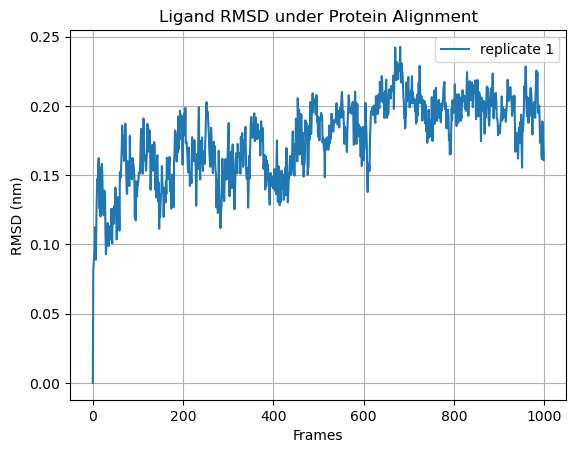

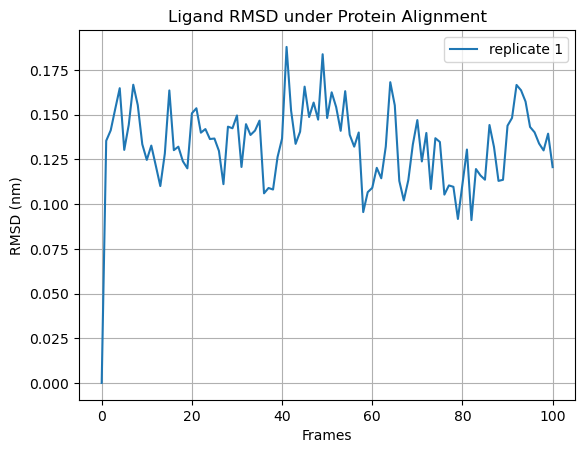

In [22]:
import mdtraj as md
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window, image_molecules=False):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        if image_molecules:
            traj.image_molecules(inplace=True)
        protein_atoms = traj.topology.select('protein and name CA')
        ligand_atoms = traj.topology.select('resname LIG')
        traj.superpose(traj, frame=0, atom_indices=protein_atoms)
        #
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'Ligand RMSD under Protein Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('Ligand RMSD Distribution under Protein Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return rmsd_arrays

crystal_openmm_sim_rmsd = plot_rmsd_fluctuations_multiple(['openmm/trajectory.dcd'], 'openmm/openmm_waters.pdb', 'line', 1, image_molecules=True)
crystal_gromacs_sim_rmsd = plot_rmsd_fluctuations_multiple(['gromacs/whole.xtc'], 'openmm/openmm_waters.pdb', 'line', 1, image_molecules=False)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


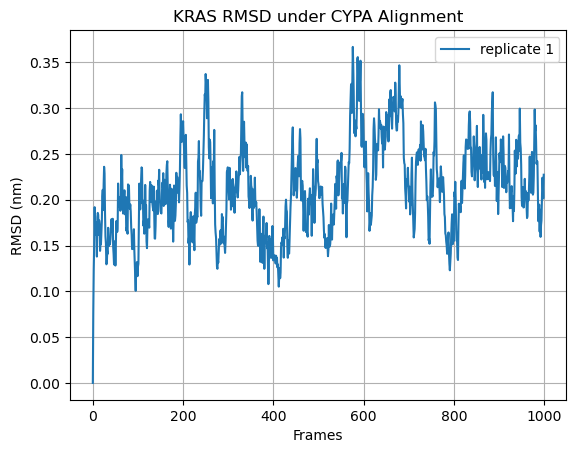

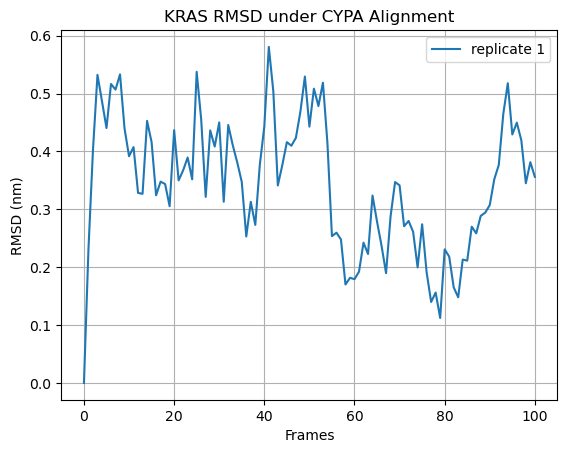

In [23]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window, image_molecules=False):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        if image_molecules:
            traj.image_molecules(inplace=True)
        CYPA_atoms = traj.topology.select('protein and chainid 1 and name CA')
        KRAS_atoms = traj.topology.select('protein and chainid 0 and name CA')
        traj.superpose(traj, frame=0, atom_indices=CYPA_atoms)
        #
        result = traj.xyz[:, KRAS_atoms, :] - traj.xyz[0, KRAS_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'KRAS RMSD under CYPA Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('KRAS RMSD Distribution under CYPA Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return rmsd_arrays

crystal_openmm_sim_rmsd = plot_rmsd_fluctuations_multiple(['openmm/trajectory.dcd'], 'openmm/openmm_waters.pdb', 'line', 1, image_molecules=True)
crystal_gromacs_sim_rmsd = plot_rmsd_fluctuations_multiple(['gromacs/whole.xtc'], 'openmm/openmm_waters.pdb', 'line', 1, image_molecules=False)